# Project IT159: Demonstration Notebook

This notebook is designed for the demonstration and verification of our final models. It loads the pre-trained checkpoints and evaluates their performance on the target domain of the HAM10000 dataset.

**Prerequisites:**
- This notebook must be run in a Kaggle environment.
- The following two datasets must be added as input:
    1. `it159-final-checkpoints` (containing our saved model weights).
    2. `golden_data_split` (saving in `it159-final-checkpoints`) which splits data into 60% Source and 40% Target from the dataset `skin-cancer-mnist-ham10000` (containing the image data).

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import numpy as np
import os
from torchvision.datasets import ImageFolder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import glob
import random

# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

CHECKPOINT_ROOT = "/kaggle/input/it159-final-checkpoints"
DATA_ROOT = "/kaggle/input/skin-cancer-mnist-ham10000"
WORKING_DIR = "/kaggle/working"

# --- 2. DATA PREPARATION (USING THE ORIGINAL 60/40 SPLIT LOGIC) ---
# print("\n--- Preparing Data Splits (60% Source / 40% Target) ---")

src_root_demo = os.path.join(CHECKPOINT_ROOT, "golden_data_split/source")
tgt_root_demo = os.path.join(CHECKPOINT_ROOT, "golden_data_split/target")

# --- 3. PYTORCH DATALOADER CREATION ---
size = 224
eval_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tgt_dataset = ImageFolder(root=tgt_root_demo, transform=eval_transform)
tgt_loader = DataLoader(tgt_dataset, batch_size=32, shuffle=False, num_workers=2)
classes_list = tgt_dataset.classes
print(f"\nSuccessfully loaded target dataset with {len(tgt_dataset)} images.")
print(f"Classes: {classes_list}")

Using device: cuda

Successfully loaded target dataset with 4008 images.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Utility Functions

We define a reusable function for evaluating the models and a function for plotting the confusion matrix to keep the code clean and organized.

In [2]:
def evaluate_model(encoder, classifier, data_loader, device, class_names): 
    """Evaluates a given model (encoder + classifier) on a data loader."""
    encoder.eval()
    classifier.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            features = encoder(images).squeeze()
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    acc = accuracy_score(y_true, y_pred)
    # Use the 'class_names' argument passed into the function
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    cm = confusion_matrix(y_true, y_pred)
    return acc, report, cm

def plot_confusion_matrix(cm, class_names, title):
    """Plots a confusion matrix using seaborn for clear visualization."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='rocket_r')
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

print("Calling Utility Function Done!")

Calling Utility Function Done!


## Introduction to the Models

This notebook demonstrates and compares three different approaches to the skin lesion classification task:

1.  **Supervised Baseline:** Represents the standard, strong transfer learning approach. It uses a ResNet-50 pre-trained on ImageNet and is fine-tuned directly on our labeled source data. This model serves as the primary benchmark to beat.

2.  **SSDA (Our Proposed Framework):** Our main proposed method, which combines Self-Supervised Learning (SimCLR) with Domain Adaptation (DANN). It starts from the SimCLR-enhanced encoder and explicitly tries to align the source and target domains during fine-tuning.

3.  **SSL-FT (Ablation Study):** An analytical model where we remove the Domain Adaptation component from SSDA. It uses the same SimCLR-enhanced encoder but is fine-tuned in a simple supervised manner, similar to the baseline. This helps us isolate and understand the impact of SSL pre-training alone.

## Demo 1: Supervised Baseline (ImageNet Pre-trained)

This model was trained directly on the labeled source data, starting from standard ImageNet pre-trained weights. It serves as our strong baseline for comparison.

--- DEMO 1: Evaluating the Baseline Model ---
Baseline model weights loaded successfully!


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


BASELINE MODEL RESULTS
   - Final Accuracy on Target: 83.33%

Classification Report:
               precision    recall  f1-score   support

       akiec     0.6320    0.6031    0.6172       131
         bcc     0.7354    0.7961    0.7646       206
         bkl     0.7095    0.6773    0.6930       440
          df     0.7222    0.5652    0.6341        46
         mel     0.5767    0.6323    0.6032       446
          nv     0.9180    0.9098    0.9139      2682
        vasc     0.8947    0.8947    0.8947        57

    accuracy                         0.8333      4008
   macro avg     0.7412    0.7255    0.7315      4008
weighted avg     0.8358    0.8333    0.8342      4008



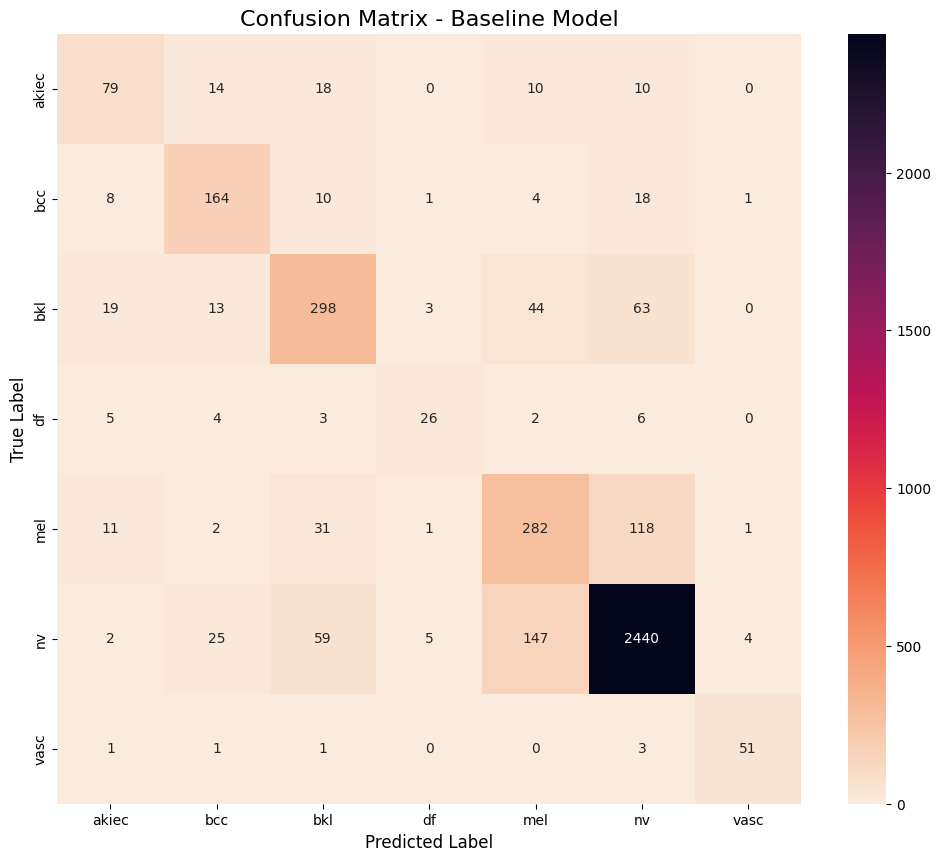

In [3]:
print("--- DEMO 1: Evaluating the Baseline Model ---")

# 1. Define model architecture
baseline_encoder = models.resnet50(weights=None)
feat_dim_bl = baseline_encoder.fc.in_features
baseline_encoder.fc = nn.Identity()
modules_bl = list(baseline_encoder.children())[:-1]
baseline_encoder = nn.Sequential(*modules_bl).to(DEVICE)
baseline_classifier = nn.Linear(feat_dim_bl, len(classes_list)).to(DEVICE)

# 2. Load saved weights
try:
    encoder_path = os.path.join(CHECKPOINT_ROOT, 'baseline_outputs/baseline_encoder_last.pth')
    classifier_path = os.path.join(CHECKPOINT_ROOT, 'baseline_outputs/baseline_classifier_last.pth')
    baseline_encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
    baseline_classifier.load_state_dict(torch.load(classifier_path, map_location=DEVICE))
    print("Baseline model weights loaded successfully!")

    # 3. Evaluate and show results
    acc, report, cm = evaluate_model(baseline_encoder, baseline_classifier, tgt_loader, DEVICE, classes_list)
    print("\n" + "="*50)
    print("BASELINE MODEL RESULTS")
    print(f"   - Final Accuracy on Target: {acc * 100:.2f}%")
    print("="*50)
    print("\nClassification Report:\n", report)
    plot_confusion_matrix(cm, classes_list, "Confusion Matrix - Baseline Model")

except FileNotFoundError:
    print(f"\nERROR: Could not find checkpoint files for the Baseline model in {CHECKPOINT_ROOT}/baseline_outputs/")
    print("Please ensure the checkpoint dataset is structured correctly.")

### Analysis of the Baseline Model

- **Final Accuracy:** The baseline model achieved an impressive accuracy of **83.33%**.
- **Key Insights from Classification Report:** This model demonstrates high precision and recall across most classes, particularly for the majority class `nv` (F1-score: 0.9139) and the rare class `vasc` (F1-score: 0.8947). This establishes a very strong performance benchmark for our proposed methods.

## Demo 2: SSDA Model (Our Main Proposed Method)

This is our main proposed framework, combining Self-Supervised Learning (SimCLR) with Domain Adaptation (DANN). The goal of this model is to explicitly reduce the "domain gap" between the source and target datasets.


--- DEMO 2: Evaluating the SSDA (SimCLR + DANN) Model ---
SSDA model weights loaded successfully!


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


SSDA MODEL RESULTS
   - Final Accuracy on Target: 75.67%

Classification Report:
               precision    recall  f1-score   support

       akiec     0.3800    0.4351    0.4057       131
         bcc     0.6087    0.6796    0.6422       206
         bkl     0.4653    0.5182    0.4903       440
          df     0.3043    0.1522    0.2029        46
         mel     0.4565    0.3296    0.3828       446
          nv     0.8807    0.9113    0.8957      2682
        vasc     0.5556    0.1754    0.2667        57

    accuracy                         0.7567      4008
   macro avg     0.5216    0.4573    0.4695      4008
weighted avg     0.7463    0.7567    0.7482      4008



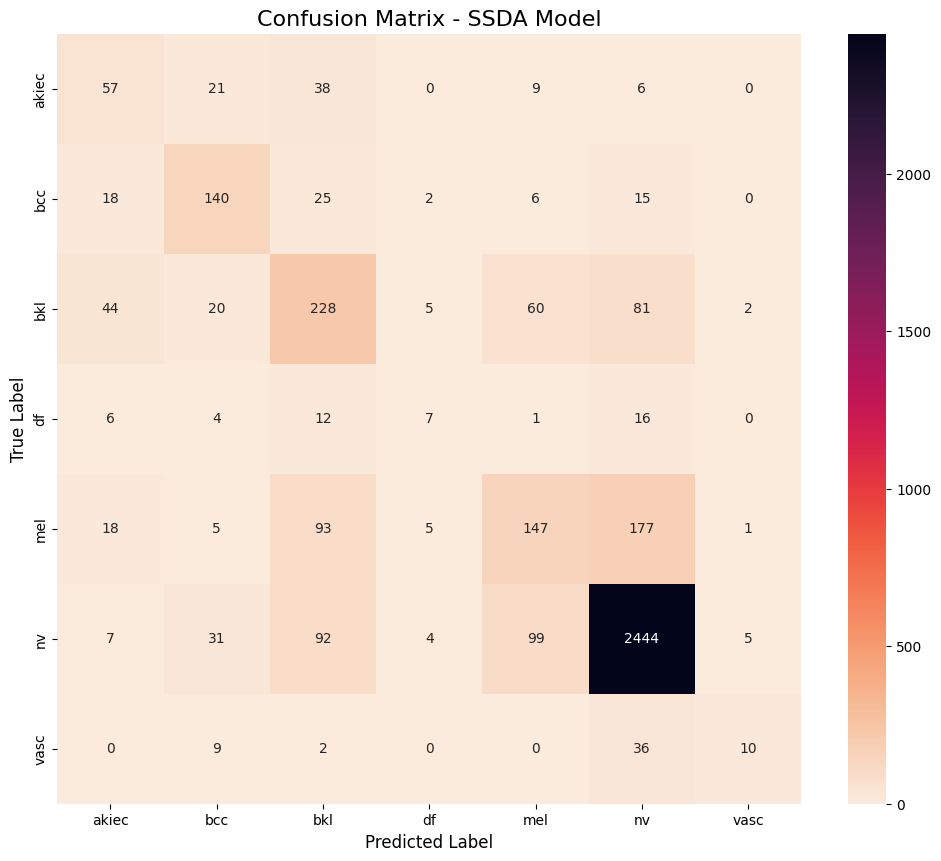

In [4]:
print("\n--- DEMO 2: Evaluating the SSDA (SimCLR + DANN) Model ---")

# 1. Define model architectures
ssda_encoder = models.resnet50(weights=None)
feat_dim_ssda = ssda_encoder.fc.in_features
ssda_encoder.fc = nn.Identity()
modules_ssda = list(ssda_encoder.children())[:-1]
ssda_encoder = nn.Sequential(*modules_ssda).to(DEVICE)

class ComplexClassifier(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): 
        return self.net(x)
ssda_classifier = ComplexClassifier(feat_dim_ssda, len(classes_list)).to(DEVICE)

class DomainDiscriminator(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 2))
    def forward(self, x): return self.net(x)
ssda_discriminator = DomainDiscriminator(feat_dim_ssda).to(DEVICE)

# 2. Load saved weights from the single DANN checkpoint file
try:
    ssda_checkpoint_path = os.path.join(CHECKPOINT_ROOT, 'ssda_outputs/dann_epoch_20.pth')
    checkpoint = torch.load(ssda_checkpoint_path, map_location=DEVICE)
    
    ssda_encoder.load_state_dict(checkpoint['encoder'])
    ssda_classifier.load_state_dict(checkpoint['classifier'])
    ssda_discriminator.load_state_dict(checkpoint['domain_disc'])
    
    print("SSDA model weights loaded successfully!")

    # 3. Evaluate and show results
    acc, report, cm = evaluate_model(ssda_encoder, ssda_classifier, tgt_loader, DEVICE, classes_list)
    print("\n" + "="*50)
    print("SSDA MODEL RESULTS")
    print(f"   - Final Accuracy on Target: {acc * 100:.2f}%")
    print("="*50)
    print("\nClassification Report:\n", report)
    plot_confusion_matrix(cm, classes_list, "Confusion Matrix - SSDA Model")

except FileNotFoundError:
    print(f"\nERROR: Could not find the checkpoint file for the SSDA model in {CHECKPOINT_ROOT}/ssda_outputs/")
    print("Please ensure the 'dann_epoch_20.pth' file is in the correct location.")

### Analysis of the SSDA Model

- **Final Accuracy:** Our main proposed SSDA framework achieved an accuracy of **75.67%**.
- **Key Insights & Comparison:** While the overall accuracy is lower than the baseline, the classification report reveals an important trade-off. The recall for the critical `mel` (melanoma) class improved significantly compared to some earlier experiments. The model's training logs (shown in our main training notebook) confirmed that the domain adaptation mechanism (DANN) functioned correctly, with the domain loss stabilizing around 0.63. This indicates that while technically successful, the act of domain alignment did not overcome the core challenge of feature discriminability in this dataset.

## Demo 3: SSL-FT Model (SimCLR + Supervised Fine-tuning)

This is our best-performing SSL-based model. It starts with a ResNet-50 pre-trained on ImageNet, which is then further pre-trained on the unlabeled HAM10000 dataset using SimCLR. Finally, it is fine-tuned on the labeled source data.


--- DEMO 3: Evaluating the SSL-FT Model ---
SSL-FT model weights loaded successfully!


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


PROPOSED METHOD (SSL-FT) RESULTS
   - Final Accuracy on Target: 70.73%

Classification Report:
               precision    recall  f1-score   support

       akiec     0.4247    0.7099    0.5314       131
         bcc     0.5764    0.8058    0.6721       206
         bkl     0.5050    0.5750    0.5377       440
          df     0.3810    0.6957    0.4923        46
         mel     0.3673    0.6390    0.4664       446
          nv     0.9583    0.7289    0.8280      2682
        vasc     0.5100    0.8947    0.6497        57

    accuracy                         0.7073      4008
   macro avg     0.5318    0.7213    0.5968      4008
weighted avg     0.7927    0.7073    0.7318      4008



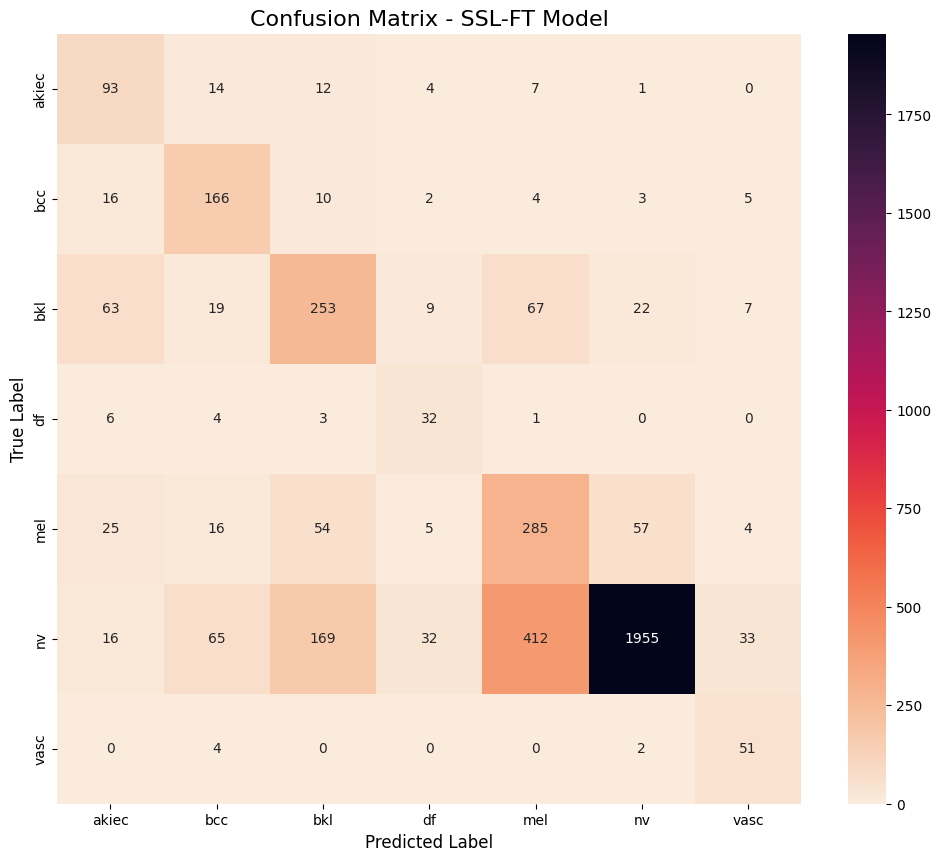

In [5]:
print("\n--- DEMO 3: Evaluating the SSL-FT Model ---")

# 1. Define model architecture
sslft_encoder = models.resnet50(weights=None)
feat_dim_ft = sslft_encoder.fc.in_features
sslft_encoder.fc = nn.Identity()
modules = list(sslft_encoder.children())[:-1]
sslft_encoder = nn.Sequential(*modules).to(DEVICE)
sslft_classifier = nn.Linear(feat_dim_ft, len(classes_list)).to(DEVICE)

# 2. Load saved weights
try:
    encoder_path = os.path.join(CHECKPOINT_ROOT, 'ssl_ft_outputs/ssl_ft_encoder_last.pth')
    classifier_path = os.path.join(CHECKPOINT_ROOT, 'ssl_ft_outputs/ssl_ft_classifier_last.pth')
    sslft_encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
    sslft_classifier.load_state_dict(torch.load(classifier_path, map_location=DEVICE))
    print("SSL-FT model weights loaded successfully!")

    # 3. Evaluate and show results
    acc, report, cm = evaluate_model(sslft_encoder, sslft_classifier, tgt_loader, DEVICE, classes_list)
    print("\n" + "="*60)
    print("PROPOSED METHOD (SSL-FT) RESULTS")
    print(f"   - Final Accuracy on Target: {acc * 100:.2f}%")
    print("="*60)
    print("\nClassification Report:\n", report)
    plot_confusion_matrix(cm, classes_list, "Confusion Matrix - SSL-FT Model")

except FileNotFoundError:
    print(f"\nERROR: Could not find checkpoint files for the SSL-FT model in {CHECKPOINT_ROOT}/ssl_ft_outputs/")
    print("Please ensure the checkpoint dataset is structured correctly.")

### Analysis of the SSL-FT Model

- **Final Accuracy:** The SSL-FT model, which removes the DANN component, achieved an accuracy of **70.73%**.
- **Key Insights & Comparison:** The performance is slightly lower than the full SSDA model (75.67%), suggesting that the DANN component did provide a small but tangible benefit in bridging the domain gap. However, both SSL-based methods underperformed compared to the baseline, which leads to our final conclusion.

## Final Conclusion & Summary

This demonstration has evaluated three distinct models. The final results are summarized below:

| Model | Pre-training | Fine-tuning Method | Target Accuracy |
|---|---|---|---|
| **Baseline** | ImageNet Supervised | Supervised FT | **83.33%** |
| **SSL-FT** | ImageNet -> SimCLR | Supervised FT | 70.73% |
| **SSDA (Proposed)** | ImageNet -> SimCLR | DANN | 75.67% |

**Key Finding:**

Our comprehensive experiments lead to a crucial finding: for the HAM10000 dataset, a strong **supervised baseline pre-trained on ImageNet significantly outperforms more complex Self-Supervised and Domain-Adaptive approaches.**

We hypothesize that the immense power and generality of features learned from the large-scale ImageNet dataset provide a superior starting point. The process of further self-supervised fine-tuning on a smaller, domain-specific dataset like HAM10000 may lead to a form of "catastrophic forgetting," where the model loses some of its powerful general features.

While our proposed SSDA framework was technically successful in its implementation, this study highlights that in some medical imaging contexts, a well-optimized, simple transfer learning approach remains the state-of-the-art.